In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def F1(model,X,Y) :
    Y_model =model.predict(X)
    f1_scor = f1_score(Y,Y_model)
    return(f1_scor)

def result_model(model,X,Y, mat = True):
    Y_model =model.predict(X)

    f1_scor = f1_score(Y,Y_model)
    print('Le f1 score vaut',f1_scor)

    if mat:
        # Matrice de confusion
        cm_model = confusion_matrix(Y, Y_model)
        plt.rcParams['figure.figsize'] = (5, 5)
        sns.heatmap(cm_model, annot = True)
        plt.title(str(model))
        plt.show()

# Random Forest

## Téléchargement des données

In [36]:
train = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v1.csv")

In [37]:
train.head(3)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,30,1,28,0,1,1,26891,3,270,1
1,0,28,1,28,1,0,0,45434,0,146,0
2,0,32,1,47,0,1,0,2630,3,195,1


## Pre-processing

On sépare la variable à expliquer des variables explicatives.

In [38]:
X = train.drop(columns='Response')
Y = train['Response']

On sépare les données en train et test.

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.85)

scaler=StandardScaler() 

X_scal_train = scaler.fit_transform(X_train)
X_scal_test = scaler.transform(X_test) 

X_scal_train = pd.DataFrame(X_scal_train,index= X_train.index)
X_scal_test = pd.DataFrame(X_scal_test,index= X_test.index)

## Implémentation

On fait un premier test avec les hyper-paramêtres par défaut 

Le f1 score vaut 0.408491107286288


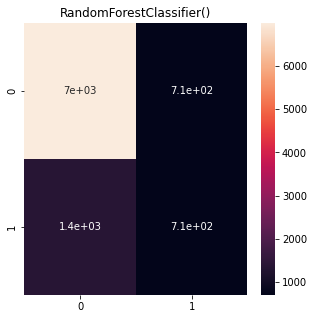

In [40]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
result_model(rfc, X_test, Y_test)

In [41]:
scores = cross_val_score(rfc, X_train, Y_train, cv=5, scoring='f1')
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores.mean(), scores.std()))

F1 moyen de 0.39 avec un écart type de 0.01


On fait aussi l'entrainement avec les variables normalisées pour voir si les résultats différents, mais ça ne semble pas être le cas.

Le f1 score vaut 0.4036962171527577


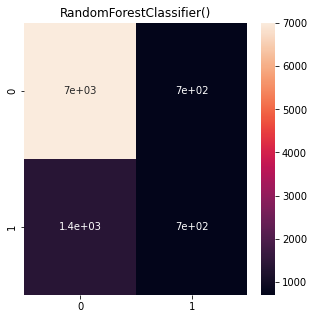

In [42]:
rfc = RandomForestClassifier()
rfc.fit(X_scal_train, Y_train)
Y_rfc = result_model(rfc, X_scal_test, Y_test)

In [43]:
scores = cross_val_score(rfc, X_scal_train, Y_train, cv=5, scoring='f1')
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores.mean(), scores.std()))

F1 moyen de 0.39 avec un écart type de 0.01


Afin d'avoir une meilleur compréhension de nos modèle on peut aussi observer quels sont les variables qui leurs apportent le plus d'informations et sont les plus importantes.

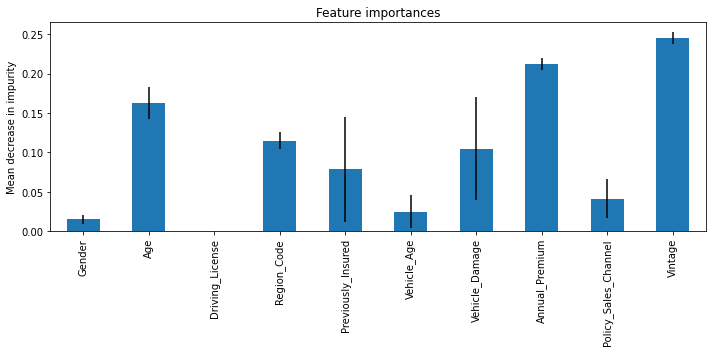

In [44]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

feature_names = [i for i in X.columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Tuning

Il y'a de nombreux paramêtres à tuner :

Nous allons intervenir sur les paramêtres suivant et procéder dans l'ordre dans lesquels les paramêtres sont présentés :

- **n_estimatorsint**, default=100, ce paramêtre correspond au nombre d'arbre, il est sans doute le plus important donc nous interviendrons deux fois dessus
- **max_depthint**, correspond à la profondeur maximal des arbres default=None
- **min_samples_splitint**, correspond au nombre de divergences nécessaire pour créer un nouveau noeud default=2
- **min_samples_leafint**, correspond au nombre minimum d'observations dans une feuille simple default=1
- **min_impurity_decreasefloat**, correspond à l'apport minimum d'une fuille pour qu'elle soit conservé default=0.0
- **n_estimatorsint**, le nombre d'arbre à nouveau, au cas où les paramêtres modifiés modifié à leur tour le nombre d'arbre optimal, default=100
- **max_features**{“auto”, “sqrt”, “log2”}, default= "auto", les 3 modes de calculs de features max qu'il faut tester
- **class_weight**{“balanced”, “balanced_subsample”}, default=None, les 2 options pour mettre des poids sur les observations

### Étape 1 : Initialisation

Rappelons, le F1 de base avant le tunning. 

In [45]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test, mat = False)

Le f1 score vaut 0.40389573188198225


### Étape 2 : n_estimators

La méthode que nous allons utiliser pour le tuning est très simple nous allons tester des valeurs parmi une liste, gardant la meilleure valeur avant de répéter le processus à avec les valeurs proches de l'optimum et en s'aidant de l'allure du graphe de nos F1 scores en fonction de nos paramêtre pour savoir dans quelle directions s'orienter.

90 0.42036775106082036


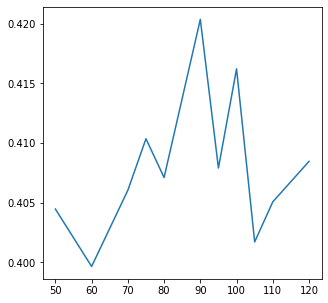

In [46]:
maxi=F1(rfc, X_test, Y_test)
kmaxi=100

T=[]
test=[50,60,70,75,80,90,95,100,105,110,120]
for k in test:
    rfc = RandomForestClassifier(max_depth=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [47]:
n_estimators_int = kmaxi
print("Nous choisissons donc",kmaxi,"comme la valeur pour le paramètre n_estimators.")

Nous choisissons donc 90 comme la valeur pour le paramètre n_estimators.


Nous n'observons pas de tendances sur le graphe donc nous pouvons nous arréter là, mais nous aurions aussi pû essayer de regarder aux alentours de 100 s'il y'avait de meilleurs prétendants.

### Étape 3 : max_depth
Nous répétons le processus pour ce paramètre, le bridant simplement à 100 maximum.

In [48]:
maxi=F1(rfc, X_test, Y_test)
kmaxi=100

100 0.408466819221968


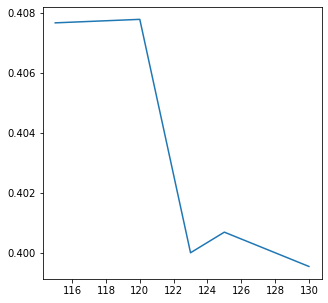

In [49]:
T=[]

test=[115,120,123,125,130]
for k in test:
    rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

Nous évaluons le f1-score actuellement.

Le f1 score vaut 0.4044431785816007


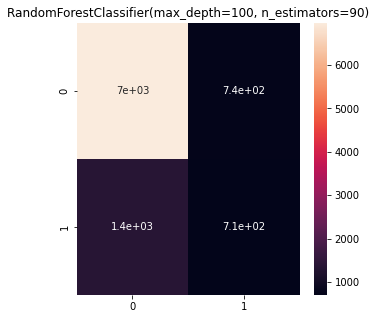

In [50]:
max_depth_int=kmaxi
rfc = RandomForestClassifier(n_estimators=n_estimators_int, max_depth=max_depth_int)
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)

maxi=F1(rfc, X_test, Y_test)
kmaxi = 2

### Étape 4 :min_samples_split

Nous répétons le processus pour le paramètre min_samples_split.

3 0.4165727170236754


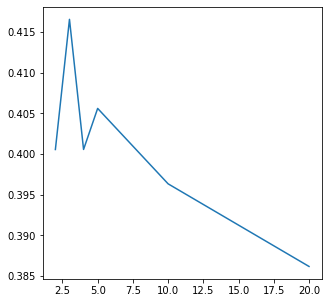

In [51]:
T=[]
test=[2,3,4,5,10,20]
for k in test:
    rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [52]:
min_samples_split_int=kmaxi
print("Nous choisissons donc",kmaxi,"comme la valeur du paramètre min_samples_split.")

Nous choisissons donc 3 comme la valeur du paramètre min_samples_split.


Le f1 score vaut 0.4060364464692483


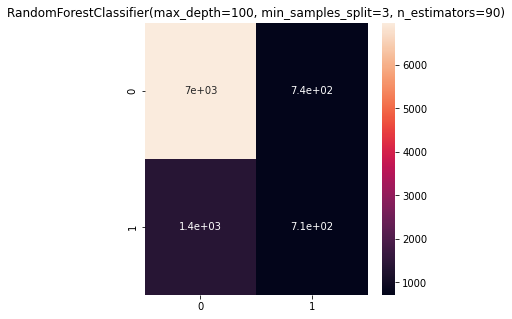

In [53]:
rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int)
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)

maxi=F1(rfc, X_test, Y_test)
kmaxi = 1

### Étape 5 : min_samples_leaf

Nous répétons le processus pour le paramètre *min_samples_leaf*.

1 0.4119148936170213


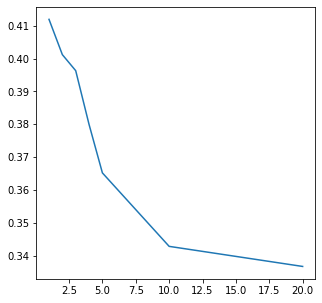

In [54]:
T=[]
test=[1,2,3,4,5,10,20]
for k in test:
    rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [55]:
min_samples_leaf_int=kmaxi
print("Nous choisissons donc",kmaxi,"comme valeur du paramètre min_samples_leaf.")

Nous choisissons donc 1 comme valeur du paramètre min_samples_leaf.


### Étape 6 : min_impurity_decrease

Nous répétons le processus pour le paramètre *min_samples_leaf*.

Le f1 score vaut 0.4146341463414634


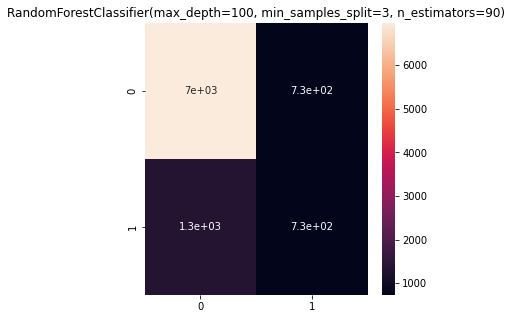

In [56]:
rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int)
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)

maxi=F1(rfc, X_test, Y_test)
kmaxi=0

0 0.4146341463414634


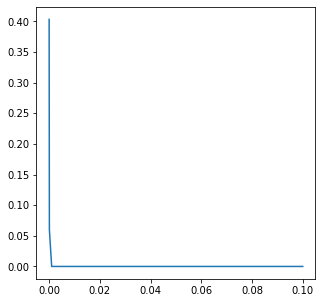

In [57]:
T=[]
test=[0,0.0001,0.001,0.05,0.1]
for k in test:
    rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [58]:
min_impurity_decrease_int=kmaxi
print("Nous choisissons donc",kmaxi,"comme valeur du paramètre min_impurity_decrease.")

Nous choisissons donc 0 comme valeur du paramètre min_impurity_decrease.


Le f1 score vaut 0.41870949563257254


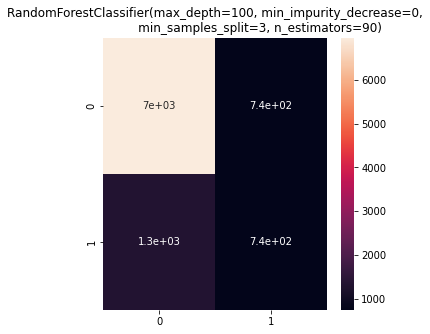

In [59]:
rfc = RandomForestClassifier(n_estimators=n_estimators_int,max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0)
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)
maxi=F1(rfc, X_test, Y_test)
kmaxi=50

### Étape 7 : n_estimators

50 0.41897685052872247


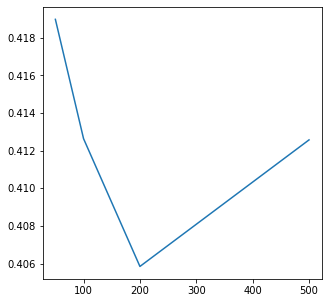

In [65]:
T=[]
test=[50,100,200,500]
for k in test:
    rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=k)
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    T.append(newF)
    if newF>maxi:
        maxi=newF
        kmaxi=k
print(kmaxi,maxi)
plt.plot(test,T)
plt.show()

In [67]:
n_estimators_int=kmaxi
print("Nous choisissons donc",kmaxi,"comme valeur du paramètre n_estimators.")

Nous choisissons donc 50 comme valeur du paramètre n_estimators.


### Étape 8 : max_features

In [68]:
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int)
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec auto F1=",newF)

rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="sqrt")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec sqrt F1=",newF)

rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int, min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec log2 F1=",newF)

avec auto F1= 0.4107496463932108
avec sqrt F1= 0.3988555078683834
avec log2 F1= 0.41231822070145424


On observe de meilleur résultat avec la valeur par défaut qui correspond au mode automatique donc nous le conservons dans notre tuning.

**log2** semble meilleur :

Le f1 score vaut 0.4057724957555178


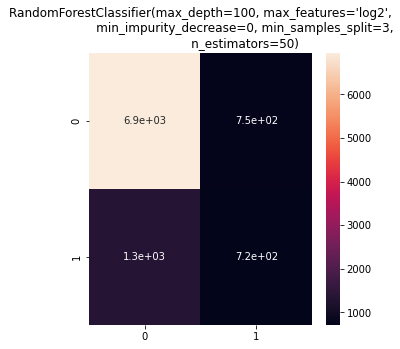

In [69]:
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2")
rfc.fit(X_train, Y_train)
Y_rfc = result_model(rfc, X_test, Y_test)
maxi=F1(rfc, X_test, Y_test)

### Étape 9 : class_weight

In [70]:
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec auto F1=",newF)
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2",
                            class_weight="balanced")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec balanced F1=",newF)
rfc = RandomForestClassifier(max_depth=max_depth_int,min_samples_split=min_samples_split_int,min_samples_leaf=min_samples_leaf_int,min_impurity_decrease=0,n_estimators=n_estimators_int,max_features="log2",
                            class_weight="balanced_subsample")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
print("avec balanced_subsample F1=",newF)

avec auto F1= 0.4096247493554855
avec balanced F1= 0.43549712407559577
avec balanced_subsample F1= 0.43081081081081085


Nos résultats sont meilleurs avec l'option de balanced weight donc nous la conservons pour notre modèle.

# Méthode tatonement aléatoire
Afin d'améliorer notre tuning nous pouvons aussi utilisés des méthodes aléatoires, leurs intérêts résside dans le fait qu'elle permettents des modifications plus subtil ou au contraire plus imprévisible et désorganisé que celle pensé par un humain, et donc inexploré.
Cette version est relativement naive et ne  possède que peu d'itération mais il est possible d'en faire une méthode beaucoup plus poussé, ce code est présent uniquement à titre d'exemple.

In [71]:
def variation(param):
    modif=np.random.randint(0,5)
    if modif==3:
        param[3]=param[3]*np.random.uniform(0.5,1.5)+np.random.uniform()/100
    if modif==0 or modif==4:
        param[modif]=int(param[modif]*np.random.uniform(0.5,1.5))+1
    else:
        param[modif]=param[modif]*np.random.uniform(0.5,1.5)
    rfc = RandomForestClassifier(max_depth=param[0],min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4],max_features="log2", class_weight="balanced")
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    return(param,newF)

In [72]:
def variation2(param):
    modif=np.random.randint(0,5)
    if modif==3:
        param[3]=param[3]*np.random.uniform(0,10)+np.random.uniform()/100
    if modif==0 or modif==4:
        param[modif]=int(param[modif]*np.random.uniform(0.5,5))+1
    else:
        param[modif]=param[modif]*np.random.uniform(0.5,1.5)
    rfc = RandomForestClassifier(max_depth=param[0],min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4],max_features="log2", class_weight="balanced")
    rfc.fit(X_train, Y_train)
    newF= F1(rfc, X_test, Y_test)
    return(param,newF)

In [73]:
param=[max_depth_int,0.5,0.25,min_impurity_decrease_int,n_estimators_int]; param

[100, 0.5, 0.25, 0, 50]

In [75]:
T=[]
rip=0
param=[max_depth_int,0.5,0.25,min_impurity_decrease_int,n_estimators_int]
rfc = RandomForestClassifier(max_depth=param[0],min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4],max_features="log2", class_weight="balanced")
rfc.fit(X_train, Y_train)
newF= F1(rfc, X_test, Y_test)
for k in range(10): #ou 100 voir 2000 pendant la nuit
    rip=rip+1
    print(k)
    nparam,nF=variation(param)
    T.append(nF)
    if nF>newF:
        newF=nF
        param=nparam
        print("+ Improvement")
        rip=0
    nparam,nF=variation2(param)
    T.append(nF)
    if nF>newF:
        newF=nF
        param=nparam
        print("+ Improvement")
        rip=0
    if rip==100:
        break


0
1
+ Improvement
2
+ Improvement
3
4
+ Improvement
5
6
7
8
9


In [76]:
param

[947, 0.11959494750571721, 0.08048576405844253, 0.030792701550521537, 88]

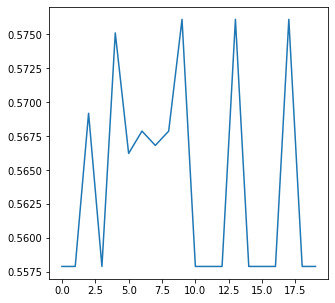

In [77]:
plt.plot(T)
plt.show()

In [78]:
rfc = RandomForestClassifier(max_depth=param[0],min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4],max_features="log2", class_weight="balanced")
rfc.fit(X_train, Y_train)
F1(rfc, X_test, Y_test)

0.5579280892684942

Au final le F1 score que nous obtenons est relativement correct sur cette base de test avec un résultat de 0.35 environ

Afin d'avoir une meilleur vision sur notre modèle dans un cas plus généralnous pouvons effectuer une cross validation qui prends plus de variété dans ses tests et évalutation.

In [79]:
scores = cross_val_score(rfc, X, Y, cv=5, scoring='f1')
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores.mean(), scores.std()))

F1 moyen de 0.55 avec un écart type de 0.01


In [82]:
param

[947, 0.11959494750571721, 0.08048576405844253, 0.030792701550521537, 88]

In [80]:
rfc = RandomForestClassifier(min_samples_split=param[1],
                             min_samples_leaf=param[2],min_impurity_decrease=param[3],
                             n_estimators=param[4], class_weight="balanced")
rfc.fit(X_train, Y_train)
F1(rfc, X_test, Y_test)

0.5579280892684942

In [81]:
scores = cross_val_score(rfc, X, Y, cv=5, scoring='f1')
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores.mean(), scores.std()))

F1 moyen de 0.56 avec un écart type de 0.01
